# HealthCare ML Project
## 1. import  Data & libraries

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb 
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, pointbiserialr
from scipy.stats import chi2_contingency
import os

In [282]:
#editor_fold
fill_na_ethnic=True # fill  'Other/Unknown' to null values in ethnich feature
output_path='output/eda/'
drop_apache=True
mpl.rcParams['axes.titlesize'] = 16  # You can adjust the size as needed


In [283]:
df=pd.read_csv('data/training_v2.csv')

In [284]:
#go to fill_na_ethnic declaration
if fill_na_ethnic:
    df['ethnicity']=df['ethnicity'].fillna('Other/Unknown')

if drop_apache:
    df.drop(columns=['apache_4a_hospital_death_prob','apache_4a_icu_death_prob'],inplace=True)

In [285]:
df.head()


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [286]:
len(df)

91713

## 2. Hospital Death distribution


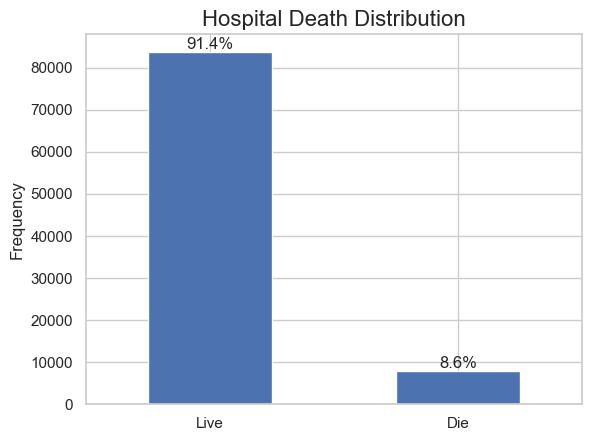

In [287]:
# Assuming data is your DataFrame with the "hospital_death" column
df["hospital_death"].value_counts().sort_index().plot(kind='bar')

# Adding labels and title
plt.ylabel('Frequency')
plt.title('Hospital Death Distribution')

# Adding percentage annotations on top of the bars
total_count = len(df["hospital_death"])
for i, count in enumerate(df["hospital_death"].value_counts().sort_index()):
    percent = count / total_count * 100
    plt.text(i, count + 20, f'{percent:.1f}%', ha='center', va='bottom')
plt.xticks([0,1],["Live",'Die'],rotation=0)
# Show the plot
plt.savefig(os.path.join(output_path,'hostpital_death_distribution.png'))

plt.show()



## 3. Exploring Variables Correlated with Hospital Deaths

The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

In [288]:
#define  continious and binary columns
binary_columns = df.columns[(df.nunique() <= 10) ]
continious_columns= df.columns[(df.nunique() >=10) & ((df.dtypes == 'int64')|(df.dtypes == 'float64'))]


In [289]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [290]:
df['hospital_death'].sum()/df['hospital_death'].count()

0.08630183289173836

In [291]:
binary_columns

Index(['hospital_death', 'elective_surgery', 'ethnicity', 'gender',
       'icu_admit_source', 'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'arf_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'apache_2_bodysystem'],
      dtype='object')

Column hospital_death is statistically significant with respect to death in hospital (p-value: 0.0)
Column elective_surgery is statistically significant with respect to death in hospital (p-value: 1.8111023373323387e-176)
Column ethnicity is statistically significant with respect to death in hospital (p-value: 0.0014283918491495892)
Column gender is statistically significant with respect to death in hospital (p-value: 0.03441709366041668)
Column icu_admit_source is statistically significant with respect to death in hospital (p-value: 3.7031521455538844e-243)
Column icu_stay_type is statistically significant with respect to death in hospital (p-value: 3.6814347425011462e-06)
Column icu_type is statistically significant with respect to death in hospital (p-value: 1.4519760772919953e-49)
Column apache_post_operative is statistically significant with respect to death in hospital (p-value: 1.6847425574384933e-141)
Column arf_apache is statistically significant with respect to death in hospi

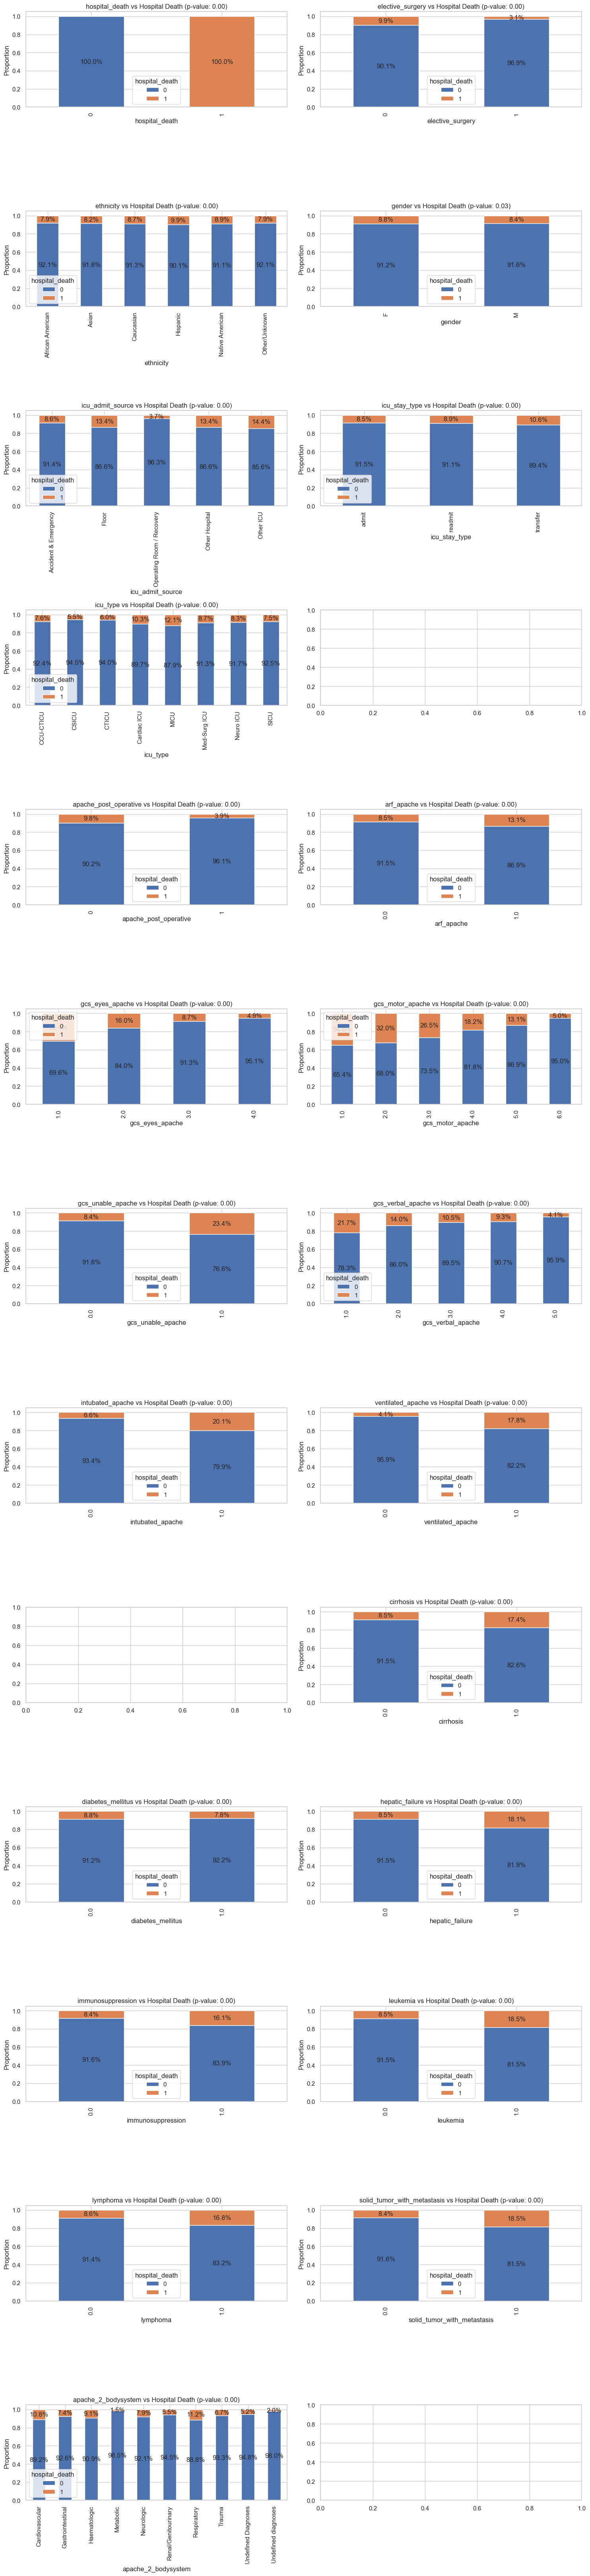

In [319]:
import math

# Determine the number of rows and columns for subplots
num_plots = len(binary_columns)
num_cols = 2  # You can choose a different number based on your preference
num_rows = math.ceil(num_plots / num_cols)

# Create a large figure to hold all subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axs = axs.flatten()  # Flatten to 1D array for easy indexing

# Iterate over each categorical column
for idx, column in enumerate(binary_columns):
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df['hospital_death'])
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Check if the result is statistically significant
    if p < 0.05:  # Common threshold for statistical significance
        print(f"Column {column} is statistically significant with respect to death in hospital (p-value: {p})")
        
         # Normalize the contingency table to show proportions
        normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

        # Plotting the normalized stacked bar chart
        ax = normalized_table.plot(kind='bar', stacked=True, ax=axs[idx])
        ax.set_title(f"{column} vs Hospital Death (p-value: {p:.2f})")
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')

        # Annotating the chart with percentages
        for c in ax.containers:
            labels = [f'{v.get_height():.1%}' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center')
        


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(os.path.join(output_path,f'categorical_cols_vs_hospital_death_chi_square.png'))

plt.show()

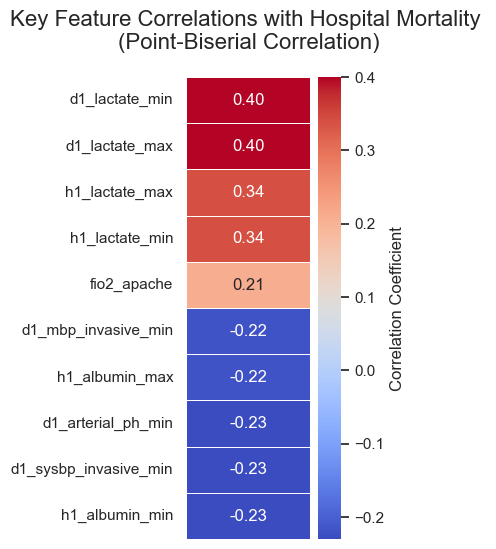

In [293]:
from matplotlib.colors import LinearSegmentedColormap


# Calculate the correlation matrix
result = []

for column in continious_columns:
    temp_df = df.loc[:, ["hospital_death", column]].dropna()
    correlation, p_value = pointbiserialr(temp_df['hospital_death'], temp_df[column])
    result.append((column, np.round(correlation, 2), p_value))

# Create a DataFrame from the result
correlation_df = pd.DataFrame(result, columns=['Variable', 'Correlation', 'P-Value']).sort_values(by='Correlation', ascending=False)
correlation_df = correlation_df.set_index('Variable')

# Select the first and last 10 rows
edge_correlation_df = pd.concat([correlation_df.head(5), correlation_df.tail(5)])


# Define a custom colormap with two pastel colors
colors = ["#9ad3bc", "#f4b6c2"]  # Light green and light pink as example colors
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=256)


# Plotting the heatmap
plt.figure(figsize=(2, 6))
heatmap = sb.heatmap(
    edge_correlation_df[['Correlation']], 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True, 
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=0.5,
    linecolor='white'
)
# Adding title and adjusting plot
plt.title('Key Feature Correlations with Hospital Mortality \n(Point-Biserial Correlation)', pad=20)
plt.xlabel('')  # Removing x label
plt.ylabel('')  # Removing y label
plt.xticks([])  # Hide x-axis ticks
plt.savefig(os.path.join(output_path, 'key_features_correlation.png'), bbox_inches='tight')

plt.show()

In [317]:
edge_correlation_df.index

Index(['d1_lactate_min', 'd1_lactate_max', 'h1_lactate_max', 'h1_lactate_min',
       'fio2_apache', 'd1_mbp_invasive_min', 'h1_albumin_max',
       'd1_arterial_ph_min', 'd1_sysbp_invasive_min', 'h1_albumin_min'],
      dtype='object', name='Variable')

T-test results:
T-statistic: -33.04024079802151
P-value: 6.332903880275223e-238

Group 1 (Hospital Death = 0) description:
count    80212.000000
mean        61.748741
std         16.860137
min         16.000000
25%         52.000000
50%         64.000000
75%         75.000000
max         89.000000
Name: age, dtype: float64

Group 2 (Hospital Death = 1) description:
count    7273.000000
mean       68.494156
std        14.428363
min        16.000000
25%        60.000000
50%        71.000000
75%        80.000000
max        89.000000
Name: age, dtype: float64


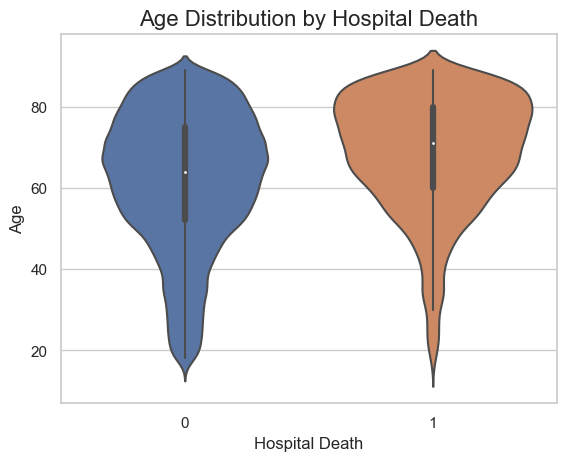

In [294]:
data_temp=df.loc[:,["hospital_death","age"]]

# Splitting the data into two groups based on 'hospital_death'
group1 = df[df['hospital_death'] == 0]['age']
group2 = df[df['hospital_death'] == 1]['age']

# Performing the t-test
t_stat, p_value = ttest_ind(group1.dropna(), group2.dropna())

# Printing the results of the t-test
print(f"T-test results:\nT-statistic: {t_stat}\nP-value: {p_value}\n")

# Describing each group
print("Group 1 (Hospital Death = 0) description:")
print(group1.describe())
print("\nGroup 2 (Hospital Death = 1) description:")
print(group2.describe())



sb.violinplot(x='hospital_death', y='age', data=data_temp)
# Adding titles and labels for clarity
plt.title('Age Distribution by Hospital Death')
plt.xlabel('Hospital Death')
plt.ylabel('Age')
plt.savefig(os.path.join(output_path,'age_vs_death.png'),bbox_inches='tight')

plt.show()


## Exploring of high correlated features


we will explore the high correlated features:
1. null values distirbution and find smart method to fill it
2. find the distribution of the correalted values and the taget column (heatlh/death)
3. Colinearity between features
https://medium.com/future-vision/collinearity-what-it-means-why-its-bad-and-how-does-it-affect-other-models-94e1db984168


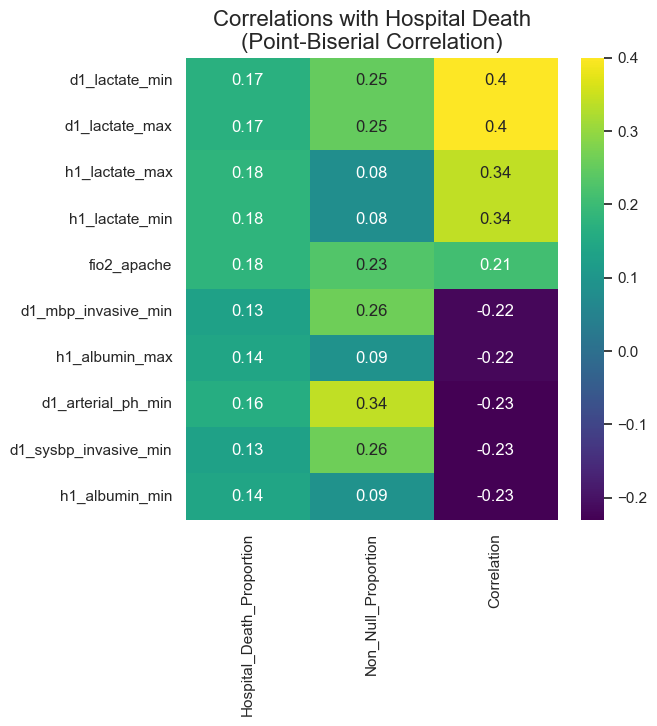

In [295]:
correlated_cols_df=df[edge_correlation_df.index]
dataset_size=len(correlated_cols_df)
result = correlated_cols_df.isna().sum() / dataset_size
dic_corr_col={}
dic_corr_col['dic_prop_col']={}
dic_corr_col['non_null_proportion']={}

for col in correlated_cols_df:
    df_dropna_temp=df[[col,"hospital_death"]].dropna()
    dic_corr_col['dic_prop_col'][col]=df_dropna_temp["hospital_death"].sum()/len(df_dropna_temp["hospital_death"])
    dic_corr_col['non_null_proportion'][col]=(dataset_size-df[col].isna().sum() )/ dataset_size
df_correlated_results=pd.DataFrame(data=dic_corr_col)
df_correlated_results.rename(columns={"dic_prop_col": "Hospital_Death_Proportion", "non_null_proportion": "Non_Null_Proportion"},inplace=True)
df_correlated_results["Correlation"]=edge_correlation_df["Correlation"]
df_correlated_results = df_correlated_results.round({'Non_Null_Proportion': 2, 'Hospital_Death_Proportion': 2,'Correlation':2})
# Plotting the heatmap
plt.figure(figsize=(6, 6))
cmap = 'viridis'
sb.heatmap(pd.DataFrame(df_correlated_results.loc[:, :]), annot=True, fmt="g", cmap=cmap)

# Adding title and adjusting plot
plt.title('Correlations with Hospital Death\n(Point-Biserial Correlation)')
plt.show()

#export df
df_correlated_results.to_csv(os.path.join(output_path,"summary_top_correlated_features.csv"))

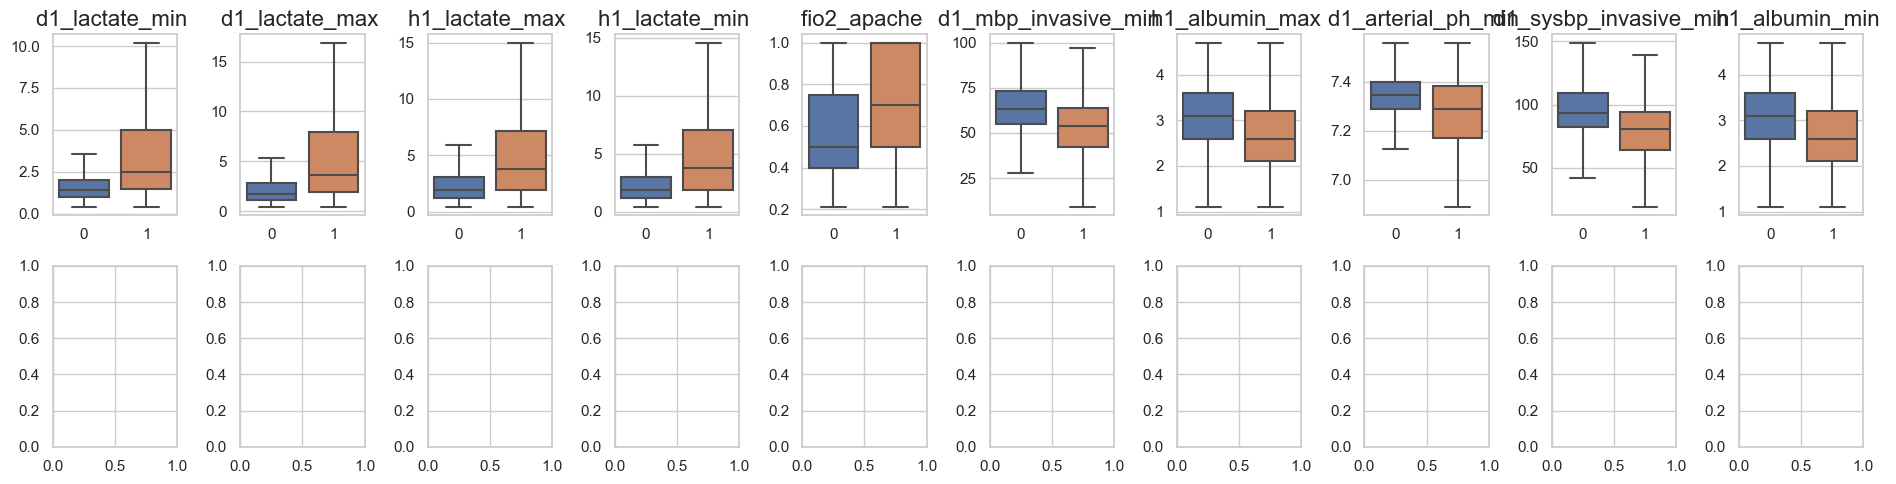

In [296]:

# Set up the matplotlib figure

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(19, 5))

# Iterate through each column and create box plots for each value of 'hospital_death'
for i, col in enumerate(correlated_cols_df.columns):
    r = i // 10  # Determine the row index
    c = i % 10   # Determine the column index
    sb.boxplot(x="hospital_death", y=col, data=df, ax=axes[r,c],showfliers =False)
    
    axes[r, c].set_title(f"{col} ")

    # Remove x-axis and y-axis label
    axes[r, c].set_xlabel('')
    axes[r, c].set_ylabel('')


    # Remove ticks
    axes[r, c].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    

# Create a single legend
legend_labels = [0,1]
plt.setp(axes[-1, :], xlabel='')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

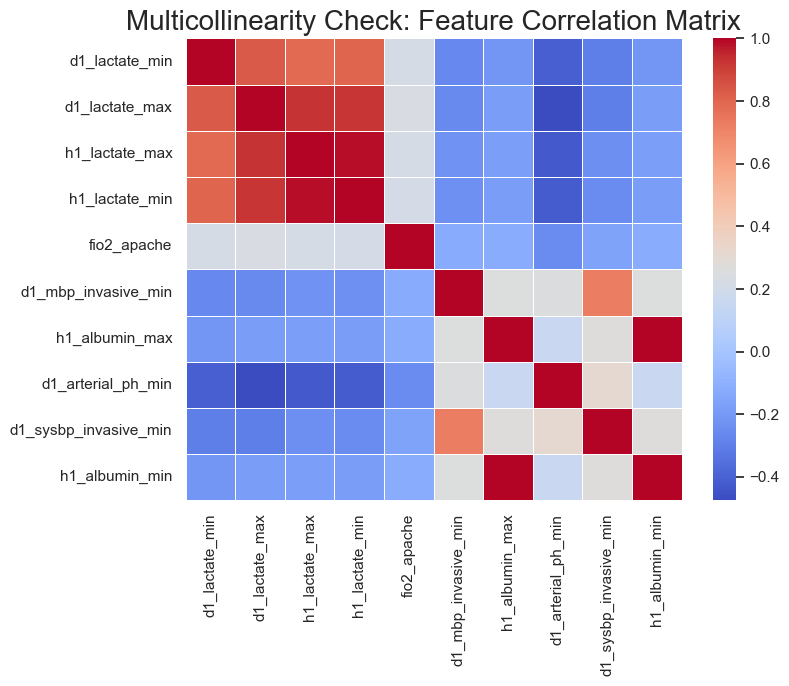

In [297]:
# Set the style for seaborn
sb.set(style="whitegrid")

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sb.heatmap(correlated_cols_df.corr(), cmap='coolwarm', linewidths=.5)

# Add a title highlighting multicollinearity
plt.title("Multicollinearity Check: Feature Correlation Matrix",size=20)
plt.savefig(os.path.join(output_path,'multicolinearity_top_features.png'), bbox_inches='tight')

# Show the plot
plt.show()


C:\Users\galbe\AppData\Local\Temp\ipykernel_49952\2924511249.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df.corr()


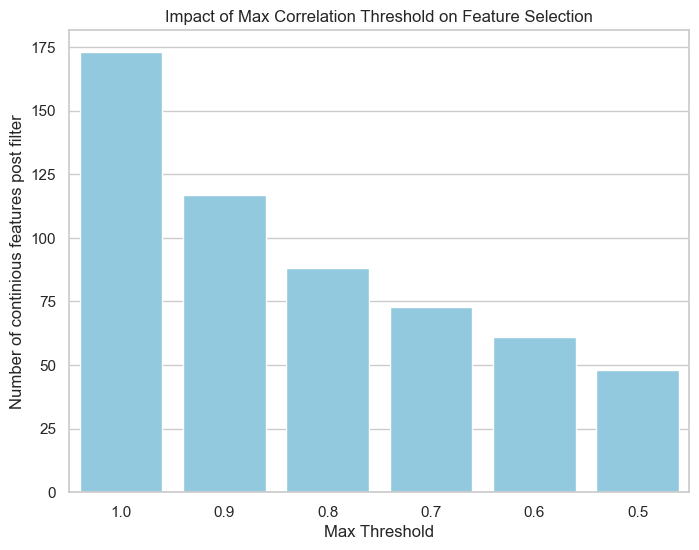

In [298]:

thresholds = np.arange(0.5,1.05, 0.1)

# Initialize an empty list to store the results
results = []
correlation_matrix=df.corr()
# Loop through each threshold and count remaining columns
for threshold in thresholds:
    # Create a mask for highly correlated columns
    mask = np.triu(np.abs(correlation_matrix) > threshold, k=1)
    
    # Count the number of columns that are not highly correlated
    remaining_columns_count = np.sum(np.sum(mask, axis=1) == 0)
    
    # Append the results to the list
    results.append({'Correlation_Threshold': threshold, 'Remaining_Columns': remaining_columns_count})

# Convert the list of dictionaries to a DataFrame using pd.concat
results_df = pd.DataFrame(results)
results_df["Correlation_Threshold"]=results_df["Correlation_Threshold"].apply(lambda x: np.round(x,1))
results_df.sort_values(by='Correlation_Threshold', ascending=False, inplace=True)
results_df.reset_index(inplace=True)
# Plotting the bar plot using Seaborn
plt.figure(figsize=(8, 6))
sb.barplot(x='Correlation_Threshold', y='Remaining_Columns', data=results_df, color='skyblue',order=results_df["Correlation_Threshold"])
plt.xlabel('Max Threshold')
plt.ylabel('Number of continious features post filter')
plt.title('Impact of Max Correlation Threshold on Feature Selection')
plt.savefig(os.path.join(output_path,'maxthreshold_vs_columns.png'),bbox_inches='tight')

plt.show()


## 4. Explorating Null Values in the Dataset







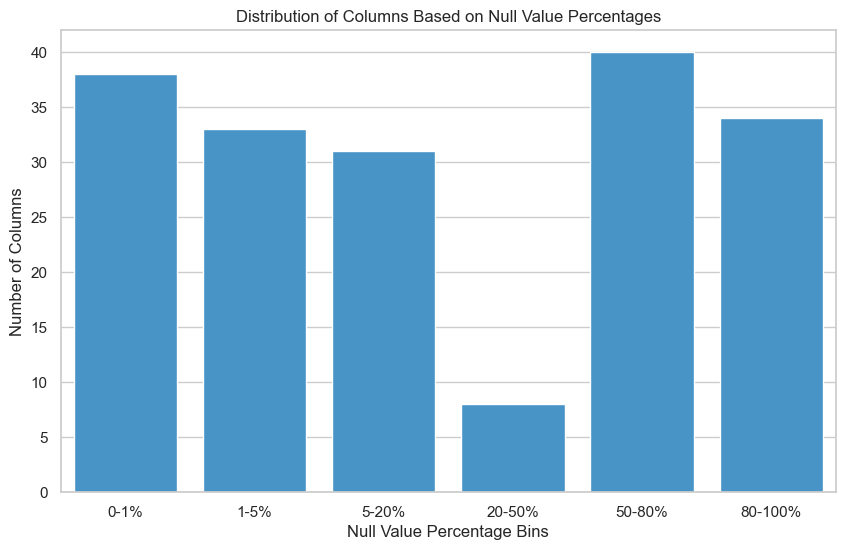

In [299]:
# Calculate the percentage of null values in each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Define the bins for categorization
bins = [-0.1, 1, 5, 20, 50, 80, 100]

# Create a new column indicating the bin for each column
bin_labels = ['0-1%', '1-5%', '5-20%', '20-50%', '50-80%', '80-100%']
null_bins = pd.cut(null_percentages, bins, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = null_bins.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sb.barplot(x=bin_counts.index, y=bin_counts.values,color='#3498db')
plt.xlabel('Null Value Percentage Bins')
plt.ylabel('Number of Columns')
plt.title('Distribution of Columns Based on Null Value Percentages')
plt.show()

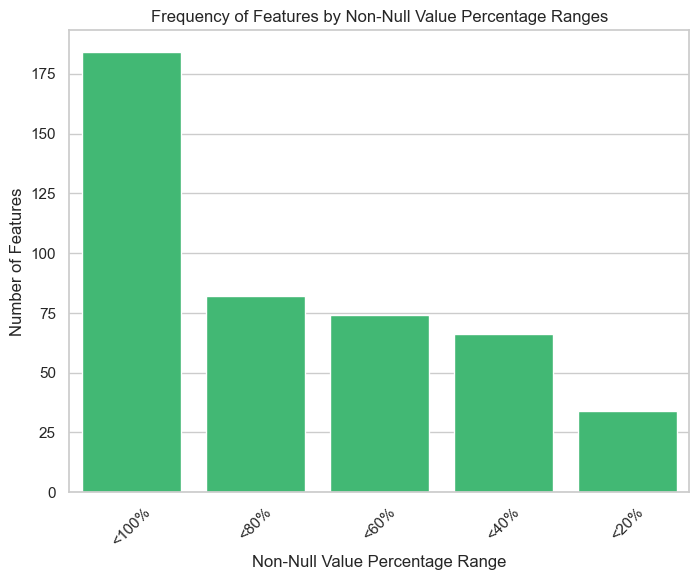

In [321]:
# Calculate the percentage of null values in each column
non_null_percentages = (df.count() / len(df)) * 100


# Define the bins for categorization
bins = [0, 20, 40, 60, 80, 100]


# Create a new column indicating the bin for each column
bin_labels = ['<20%', '<40%', '<60%', '<80%', '<100%']
non_null_bins = pd.cut(non_null_percentages, bins, labels=bin_labels)


# Count the number of columns in each bin
bin_counts = non_null_bins.value_counts().sort_index()

# Convert bin_counts to DataFrame for sorting
bin_counts_df = bin_counts.reset_index().rename(columns={'index': 'Bin', 0: 'Count'})
bin_counts_df['Cumulative'] = bin_counts_df['Count'].cumsum()

# Sort bins by count in descending order to have the highest bar on the left
bin_counts_df_sorted = bin_counts_df.sort_values(by='Cumulative', ascending=False)

# Create a bar plot for sorted bins
plt.figure(figsize=(8, 6))
sb.barplot(x='Bin', y='Cumulative', data=bin_counts_df_sorted, color='#2ecc71', order=bin_counts_df_sorted['Bin'])
plt.xlabel('Non-Null Value Percentage Range')
plt.ylabel('Number of Features')
plt.title('Frequency of Features by Non-Null Value Percentage Ranges')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_path,"Cumulative_Frequency_non_null_values_cols.png"),bbox_inches='tight')
plt.show()

In [301]:
bin_counts_df

,Bin,Count,Cumulative
0,<20%,34,34
1,<40%,32,66
2,<60%,8,74
3,<80%,8,82
4,<100%,102,184


## 5. Mann-Whitney U Test: Live vs. Deceased Groups

In [302]:
group1 = df[df["hospital_death"] == 0]
group2 = df[df["hospital_death"] == 1]

# Create a DataFrame to store p-values, means, and percentage differences
result_df = pd.DataFrame(columns=['Column', 'P-Value', 'Mean_Group_live', 'Mean_Group_die', 'Percentage Difference'])

# Iterate through each column in the DataFrame
for column in continious_columns:
    if column != "hospital_death":
        # Perform the Mann-Whitney U test for the current column
        stat, p_val = mannwhitneyu(group1[column].dropna(), group2[column].dropna(), alternative='two-sided')
        
        # Calculate the mean for each group
        mean_group1 = group1[column].mean()
        mean_group2 = group2[column].mean()
        
        # Calculate the percentage difference between the means
        percentage_difference = (np.abs(mean_group1 - mean_group2) / ((mean_group1 + mean_group2) / 2)) * 100
        
        # Store the results in the DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 
                                                        'P-Value': [np.round(p_val, 3)], 
                                                        'Mean_Group_live': [np.round(mean_group1, 2)],
                                                        'Mean_Group_die': [np.round(mean_group2, 2)],
                                                        'Percentage Difference': [np.round(percentage_difference, 2)]})],
                              ignore_index=True)

# # Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg correction)
# result_df['Adjusted P-Value'] = multipletests(result_df['P-Value'], method='fdr_bh')[1]

# Display the resulting DataFrame


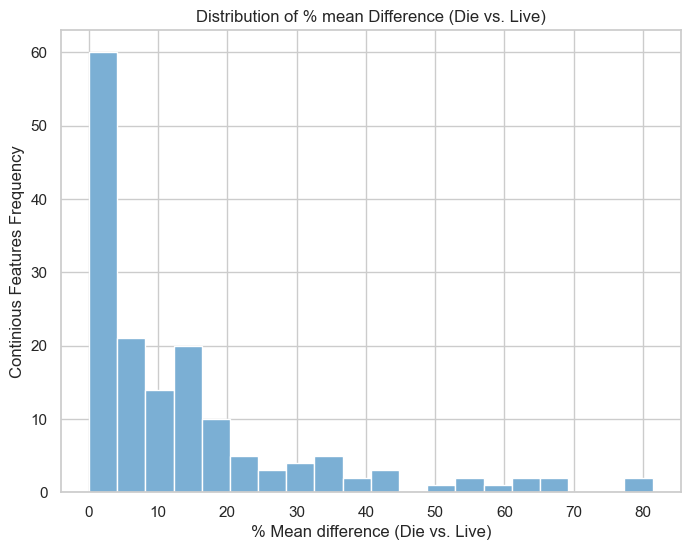

In [303]:
# Assuming your DataFrame is named 'result_df'
plt.figure(figsize=(8, 6))

# Plotting the histogram
result_df["Percentage Difference"].hist(bins=20, color='#7BAFD4')  # Adjust the color as needed

# Adding labels and title
plt.title('Distribution of % mean Difference (Die vs. Live)')
plt.xlabel('% Mean difference (Die vs. Live)')
plt.ylabel('Continious Features Frequency')
plt.savefig(os.path.join(output_path,"mean_delta_distribution.png"),bbox_inches='tight')
# Show the plot
plt.show()

In [304]:
result_df.sort_values(by="Percentage Difference",ascending=False).head(15)

,Column,P-Value,Mean_Group_live,Mean_Group_die,Percentage Difference
101,d1_lactate_max,0.0,2.37,5.62,81.40
102,d1_lactate_min,0.0,1.74,3.99,78.77
132,h1_lactate_min,0.0,2.56,5.14,67.14
131,h1_lactate_max,0.0,2.60,5.20,66.61
83,d1_bilirubin_max,0.0,1.03,1.97,62.66
12,bilirubin_apache,0.0,1.04,1.99,62.34
84,d1_bilirubin_min,0.0,0.98,1.80,59.42
113,h1_bilirubin_max,0.0,0.99,1.76,56.16
114,h1_bilirubin_min,0.0,0.99,1.76,56.12
7,pre_icu_los_days,0.0,0.79,1.35,52.53


## 6. Exploring Gender and Ethnicity Disparities 



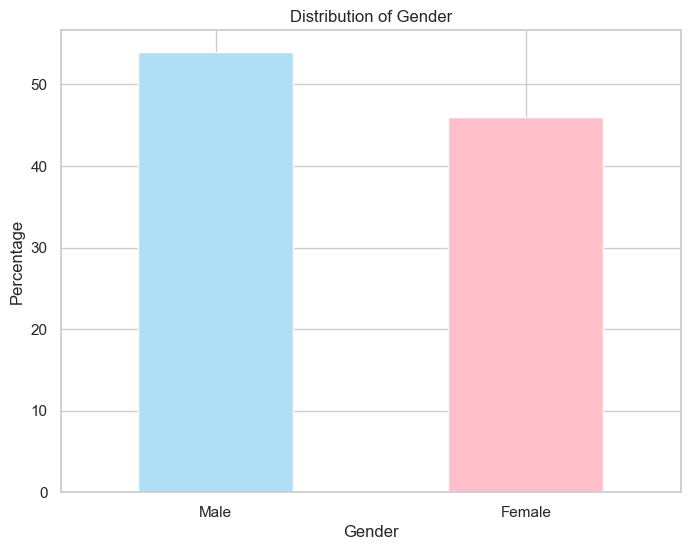

In [305]:

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

# Calculate the percentage distribution
gender_percentage = df['gender'].value_counts(normalize=True) * 100

# Plot the bar chart with percentages
gender_percentage.plot(kind='bar', color=['#AEDFF7', '#FFC0CB'])
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks([0,1],['Male','Female'],rotation=0)
plt.savefig(os.path.join(output_path,"gender_distribution.png"),bbox_inches='tight')
plt.show()


In [306]:
df['ethnicity'].unique()

array(['Caucasian', 'Other/Unknown', 'Hispanic', 'African American',
       'Asian', 'Native American'], dtype=object)

<Figure size 800x600 with 0 Axes>

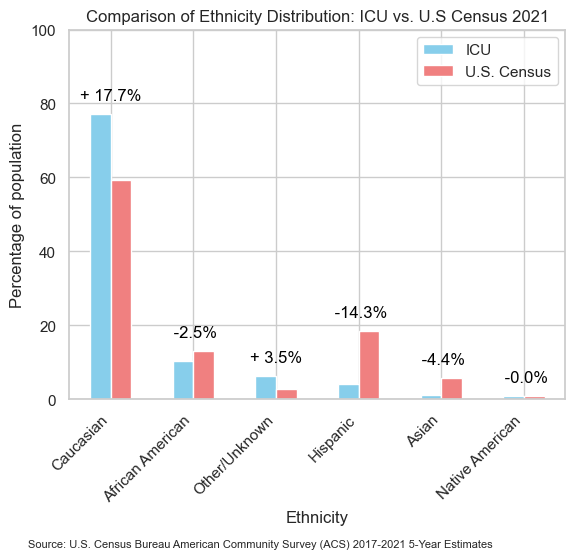

In [307]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

# Calculate the percentage distribution in the dataset https://www.neilsberg.com/insights/united-states-population-by-race/#pop-by-race
#Source: U.S. Census Bureau American Community Survey (ACS) 2017-2021 5-Year Estimates

ethnicity_percentage_dataset = df['ethnicity'].fillna('Other/Unknown').value_counts(normalize=True) * 100

# USA 2023 ethnic distribution
usa_2023_ethnic_distribution = {'Caucasian': 59.4, 'African American': 12.9, 'Native American': 0.9,
                                 'Asian': 5.6, 'Hispanic': 18.4, 'Other/Unknown': 2.8}

# Create a DataFrame for USA 2023 ethnic distribution
usa_2023_df = pd.DataFrame(list(usa_2023_ethnic_distribution.items()), columns=['Ethnicity', 'USA 2021 Ethnic Distribution %'])
usa_2023_df.set_index('Ethnicity', inplace=True)

# Merge dataset and USA 2023 ethnic distribution DataFrames
merged_df = pd.concat([ethnicity_percentage_dataset, usa_2023_df], axis=1, sort=False)
merged_df.columns = ['Dataset %', 'USA 2021 Ethnic Distribution %']

# Plot the grouped bar chart
merged_df['Delta'] = merged_df['Dataset %'] - merged_df['USA 2021 Ethnic Distribution %']
bars = merged_df.loc[:,['Dataset %','USA 2021 Ethnic Distribution %']].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Comparison of Ethnicity Distribution: ICU vs. U.S Census 2021')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of population')
plt.xticks(rotation=45, ha='right')
plt.ylim([0,100])

# Display the percentage values and delta on top of the bars
for i, (dataset_pct, usa_2023_pct, delta) in enumerate(zip(merged_df['Dataset %'], merged_df['USA 2021 Ethnic Distribution %'], merged_df['Delta'])):
    delta_text = f' {delta:.1f}%'
    if delta > 0:
        delta_text = '+' + delta_text
    plt.text(i, max(dataset_pct, usa_2023_pct) + 3, delta_text, ha='center', va='bottom', color='black')
plt.text(-1, -40, 'Source: U.S. Census Bureau American Community Survey (ACS) 2017-2021 5-Year Estimates', fontsize=8)
plt.legend(['ICU', 'U.S. Census'],loc='upper right',)
plt.savefig(os.path.join(output_path,"ethinc_distriubtion.png"),bbox_inches='tight')
plt.show()



## 7. Hospital mortality rate

we can see that there is single hospital with 50% to die, its important to note it has only 2 samples

In [308]:
print(f"there are {len(df['hospital_id'].unique())} unique hospitals")

there are 147 unique hospitals


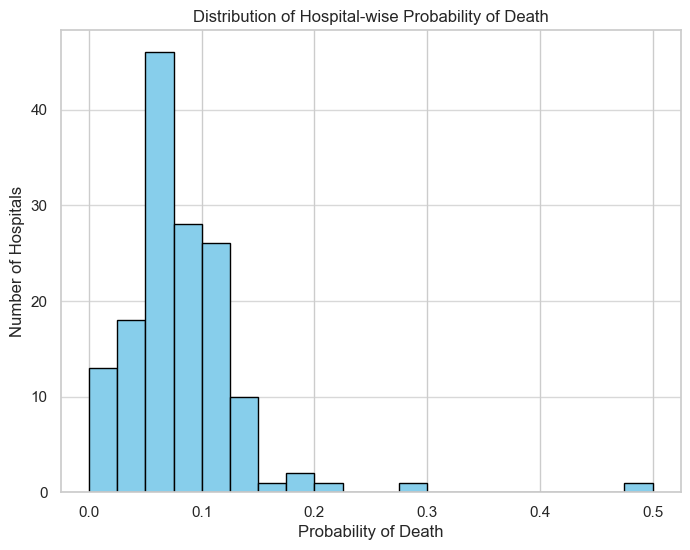

In [309]:
hospital_proportion_death=df.groupby('hospital_id')['hospital_death'].mean()
hospital_patient=df.groupby('hospital_id')['hospital_death'].count()
plt.figure(figsize=(8, 6))
plt.hist(hospital_proportion_death, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Hospital-wise Probability of Death')
plt.xlabel('Probability of Death')
plt.ylabel('Number of Hospitals')
plt.grid(axis='y', alpha=0.75)
plt.savefig(os.path.join(output_path,"mortality_rate_by_hospital.png"),bbox_inches='tight')
plt.show()


In [310]:
hospital_patient.describe()

count     147.000000
mean      623.897959
std       778.766743
min         2.000000
25%       124.000000
50%       323.000000
75%       809.500000
max      4333.000000
Name: hospital_death, dtype: float64

In [311]:
hospital_proportion_death.describe()

count    147.000000
mean       0.079973
std        0.056002
min        0.000000
25%        0.052687
50%        0.072706
75%        0.102625
max        0.500000
Name: hospital_death, dtype: float64

In [312]:
df_temp=pd.DataFrame([hospital_proportion_death,hospital_patient]).transpose()
edge_case_index_hospital_death=hospital_proportion_death[(hospital_proportion_death>0.2) |( hospital_proportion_death<0.02)].index
df_temp.columns=['Death_hospital_proportion','Number_of_patients']
df_temp=df_temp.loc[edge_case_index_hospital_death,:]
df_temp.sort_values(by='Death_hospital_proportion')
df_temp.to_csv(os.path.join(output_path,"hospital_id_summary.csv"))


In [313]:
df[df["hospital_id"]==142]["hospital_death"].count()

176

In [314]:
df['ethnicity'].unique()

array(['Caucasian', 'Other/Unknown', 'Hispanic', 'African American',
       'Asian', 'Native American'], dtype=object)

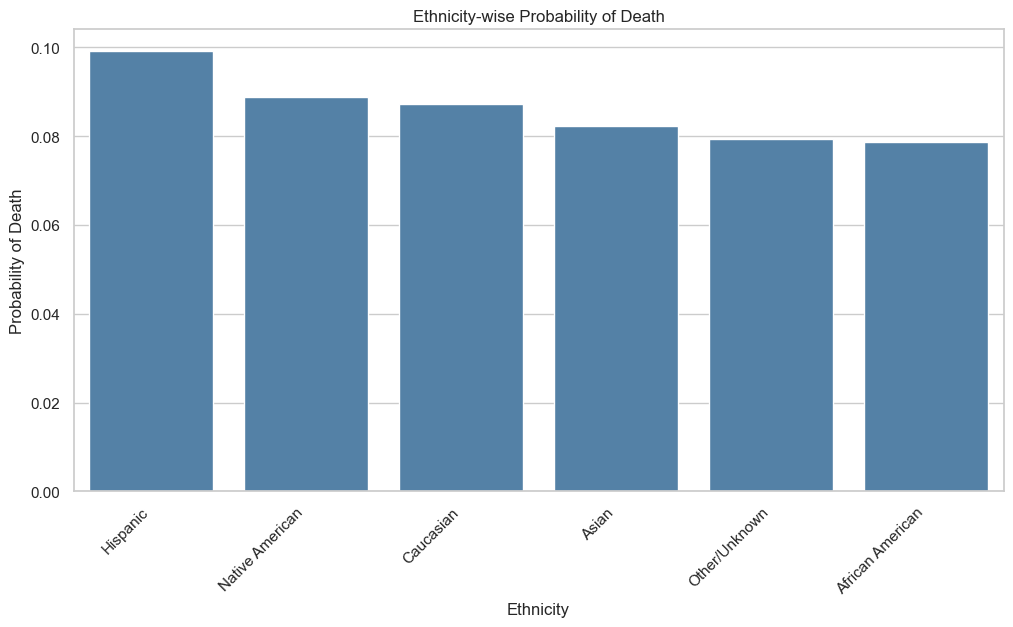

In [315]:
# Grouping data by ethnicity and calculating the mean death probability
ethnicity_death_prob = df.groupby('ethnicity')['hospital_death'].mean().reset_index()

# Sorting the data by death probability for better visualization
ethnicity_death_prob = ethnicity_death_prob.sort_values(by='hospital_death', ascending=False)

# Creating a bar plot
plt.figure(figsize=(12, 6))
sb.barplot(x='ethnicity', y='hospital_death', data=ethnicity_death_prob, color='#4682B4')
plt.title('Ethnicity-wise Probability of Death')
plt.xlabel('Ethnicity')
plt.ylabel('Probability of Death')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()